# 2024-1 Artificial Intelligence (01)
## Homework #3: Sentiment Analysis with Transformer
---
Copyright (c) Prof. Jaehyeong Sim

Department of Computer Science and Engineering

ELTEC College of Engineering

Ewha Womans University

## Guideline
### Introduction
> Here in this homework assignment 3, we will implement a transformer model for sentiment analysis using TensorFlow Keras library.

### Your job
1. Please complete the code. You only have to write the parts marked as **### Please fill here**.

### Submission guide
1. Please rename the completed skeleton file to ***STUDENT_ID*.ipynb**. Your own student ID goes to *STUDENT_ID*. For example, if your student ID is 2412345, the file name should be **2412345.ipynb**
2. Turn in it into the Ewha CyberCampus

⚠ If you doesn't follow the submission guide above, you will get **5 point deduction** from this homework score.

### Importing necessary libraries

In [39]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

### Define multi-head attention block

In [40]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        self.ff_dim = embedding_dim
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.ff = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query,key,transpose_b=True);
        d_k = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.sqrt(d_k)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, value)

        return output, attention_weights


    # result : (batch_size, num_heads, seq_len, d_model/num_heads)
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, (self.embedding_dim // self.num_heads)))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):

        # 1. Get Q, K, V by WQ, WK, WV
        # q : (batch_size, seq_len, d_model)
        # k : (batch_size, seq_len, d_model)
        # v : (batch_size, seq_len, d_model)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        batch_size = tf.shape(inputs)[0]

        # 2. Split heads
        # q : (batch_size, num_heads, seq_len, d_model/num_heads)
        # k : (batch_size, num_heads, seq_len, d_model/num_heads)
        # v : (batch_size, num_heads, seq_len, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. Scaled dot product attention
        output,_ = self.scaled_dot_product_attention(query, key, value) # (batch_size, num_heads, seq_len, d_model/num_heads)
        output = tf.transpose(output, perm=[0, 2, 1, 3]) # (batch_size, seq_len, num_heads, d_model/num_heads)

        # 4. head concatenation
        concat_attention = tf.reshape(output, (batch_size, -1, self.embedding_dim)) # (batch_size, seq_len, d_model)

        # 5. WO fully connected layer
        outputs = self.ff(concat_attention)

        return outputs


### Define transformer block

In [41]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):

      # Multi-head attention
      attention_output = self.att.call(inputs)

      # Add & Normalization
      an_output = self.dropout1(attention_output, training=training)
      an_output = self.layernorm1(inputs + an_output)

      # Feed forward
      feed_forward_output = self.ffn(an_output)

      # Add & Normalization
      output = self.dropout2(feed_forward_output, training=training)
      output = self.layernorm2(output + an_output)

      return output

### Define token and position embedding

In [42]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### Dataset preparation

In [44]:
vocab_size = 20000 # 단어의 종류
max_len = 200

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

print('Train review size : {}'.format(len(X_train)))
print('Test review size : {}'.format(len(X_test)))

Train review size : 25000
Test review size : 25000


### Pad sequences

In [45]:
X_train = pad_sequences(X_train, maxlen=max_len) # 문장의 길이를 일정하게 맞춰줌 (200글자)
X_test = pad_sequences(X_test, maxlen=max_len)

### Define the whole model
The model looks like this:

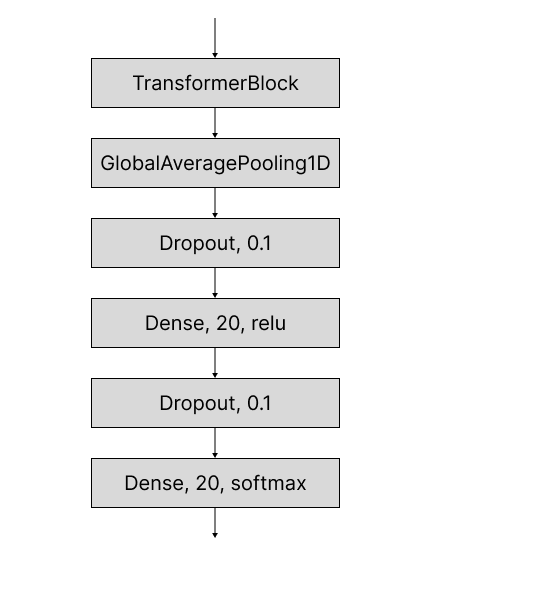

In [46]:
def Transformer(embedding_dim, num_heads, dff):
  inputs = tf.keras.layers.Input(shape=(max_len,))
  embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
  x = embedding_layer(inputs)
  tfblock = TransformerBlock(embedding_dim, num_heads, dff)
  y = tfblock.call(x,True)
  y = tf.keras.layers.GlobalAveragePooling1D()(y)
  y = tf.keras.layers.Dropout(rate=0.1)(y)
  y = tf.keras.layers.Dense(20,activation='relu')(y)
  y = tf.keras.layers.Dropout(rate=0.1)(y)
  outputs = tf.keras.layers.Dense(20,activation='softmax')(y)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

### Instantiate model

In [47]:
embedding_dim = 32  # Embedding vector dim
num_heads = 2
dff = 32  # hidden units of FCN

model = Transformer(embedding_dim, num_heads, dff)

### Complile and train

In [48]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

print("Test accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/2
782/782 [==============================] - 53s 62ms/step - loss: 0.4626 - accuracy: 0.7900 - val_loss: 0.3387 - val_accuracy: 0.8558
Epoch 2/2
782/782 [==============================] - 5s 6ms/step - loss: 0.3034 - accuracy: 0.8750
Test accuracy: 0.8750


### Predict

In [52]:
word_to_index = imdb.get_word_index()
def sentiment_predict(model, new_sentence):
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encoded = []

  for word in new_sentence.split():
    try :
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
        encoded.append(2)
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_len)
  score = float(model.predict(pad_sequence)[0][0])

  if(score > 0.5):
    print("{:.2f}% negative".format(score * 100))
  else:
    print("{:.2f}% positive".format((1 - score) * 100))

text = "This movie was just way too overrated. \
        The fighting was not professional and in slow motion. \
        I was expecting more from a 200 million budget movie. \
        The little sister of T.Challa was just trying too hard to be funny. \
        The story was really dumb as well. \
        Don't watch this movie if you are going because others say its great \
        unless you are a Black Panther fan or Marvels fan."
sentiment_predict(model, text)

1/1 [==============================] - 0s 26ms/step
79.97% negative
